In [ ]:
import pandas as pd
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import json
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import string
import spacy
import transformers
from transformers import pipeline

In [2]:
# Baixar recursos do NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /home/longras/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/longras/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/longras/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/longras/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
def load_yelp_data(file_path, nrows=None):
    data = []
    print(f" Loading: {file_path}...")  

    with open(file_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if nrows and i >= nrows:
                break
            data.append(json.loads(line))
            
            if (i + 1) % 100000 == 0:
                print(f"  🔄 {i + 1} loaded lines...")

    print(f" {file_path} loaded with {len(data)} lines!\n")  
    return pd.DataFrame(data)

print("\n Starting to load datasets...\n")




 Starting to load datasets...



In [4]:

df_business = load_yelp_data("data/yelp_academic_dataset_business.json")  # (~150K)
df_review = load_yelp_data("data/sparks_reviews.json")  # 500K
df_user = load_yelp_data("data/yelp_academic_dataset_user.json")  # 500k
#df_checkin = pd.read_json('data/yelp_academic_dataset_checkin.json', lines=True) not used for now
#df_tip = pd.read_json('data/yelp_academic_dataset_tip.json', lines=True) not used for now

 Loading: data/yelp_academic_dataset_business.json...
  🔄 100000 loaded lines...
 data/yelp_academic_dataset_business.json loaded with 150346 lines!

 Loading: data/sparks_reviews.json...
 data/sparks_reviews.json loaded with 40186 lines!

 Loading: data/yelp_academic_dataset_user.json...
  🔄 100000 loaded lines...
  🔄 200000 loaded lines...
  🔄 300000 loaded lines...
  🔄 400000 loaded lines...
  🔄 500000 loaded lines...
  🔄 600000 loaded lines...
  🔄 700000 loaded lines...
  🔄 800000 loaded lines...
  🔄 900000 loaded lines...
  🔄 1000000 loaded lines...
  🔄 1100000 loaded lines...
  🔄 1200000 loaded lines...
  🔄 1300000 loaded lines...
  🔄 1400000 loaded lines...
  🔄 1500000 loaded lines...
  🔄 1600000 loaded lines...
  🔄 1700000 loaded lines...
  🔄 1800000 loaded lines...
  🔄 1900000 loaded lines...
 data/yelp_academic_dataset_user.json loaded with 1987897 lines!



In [6]:
# selecionar business de restaurants

# Filtrar apenas os restaurantes
df_restaurants = df_business[df_business["categories"].str.contains("Restaurants", na=False, case=False)]


In [8]:
df_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."


In [5]:
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [14]:
df_business.shape



(150346, 14)

In [15]:
df_business.describe()

,latitude,longitude,stars,review_count,is_open
count,150346.000000,150346.000000,150346.000000,150346.000000,150346.00000
mean,36.671150,-89.357339,3.596724,44.866561,0.79615
std,5.872759,14.918502,0.974421,121.120136,0.40286
min,27.555127,-120.095137,1.000000,5.000000,0.00000
25%,32.187293,-90.357810,3.000000,8.000000,1.00000
50%,38.777413,-86.121179,3.500000,15.000000,1.00000
75%,39.954036,-75.421542,4.500000,37.000000,1.00000
max,53.679197,-73.200457,5.000000,7568.000000,1.00000


In [9]:
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [16]:
df_review.shape

(500000, 9)

In [17]:
df_review.describe()

,stars,useful,funny,cool
count,500000.000000,500000.000000,500000.000000,500000.000000
mean,3.806634,1.028570,0.285922,0.410568
std,1.418262,2.409103,1.245599,1.437532
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,320.000000,284.000000,164.000000


In [10]:
df_user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


In [19]:
df_user.shape

(500000, 22)

In [20]:
df_user.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,45.575254,97.904300,40.731620,59.324422,3.336026,3.737755,4.374262,0.690274,0.455974,0.323376,0.177448,3.468444,7.650252,6.950604,6.950604,2.624452,3.065048
std,137.344245,1110.846225,694.698189,977.405574,32.990892,0.955567,118.549161,23.872525,28.329878,21.696780,19.604651,100.550284,215.227112,159.829144,159.829144,54.844470,172.913698
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,2.000000,0.000000,0.000000,0.000000,3.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,8.000000,1.000000,2.000000,0.000000,3.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.000000,30.000000,6.000000,8.000000,1.000000,4.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,17473.000000,206296.000000,185823.000000,199878.000000,12497.000000,5.000000,25784.000000,13501.000000,14180.000000,13654.000000,12669.000000,59031.000000,101097.000000,49967.000000,49967.000000,15934.000000,82630.000000


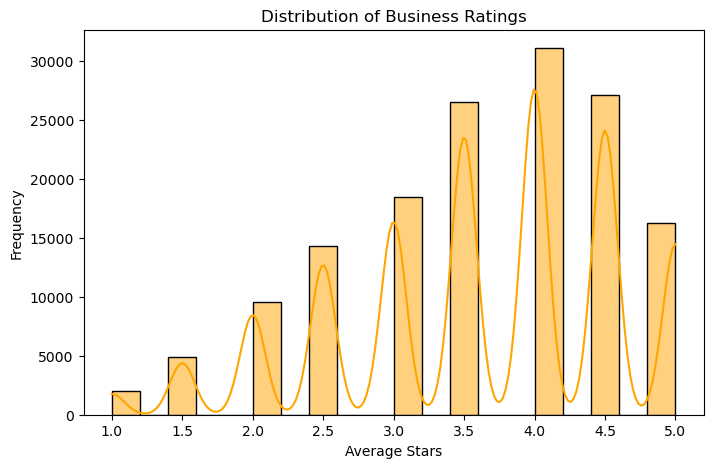

In [25]:
plt.figure(figsize=(8, 5))
sns.histplot(df_business['stars'], bins=20, kde=True, color="orange")
plt.title("Distribution of Business Ratings")
plt.xlabel("Average Stars")
plt.ylabel("Frequency")
plt.show()


/tmp/ipykernel_3895/3075740025.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_business, x="name", y="review_count", palette="Blues_d")


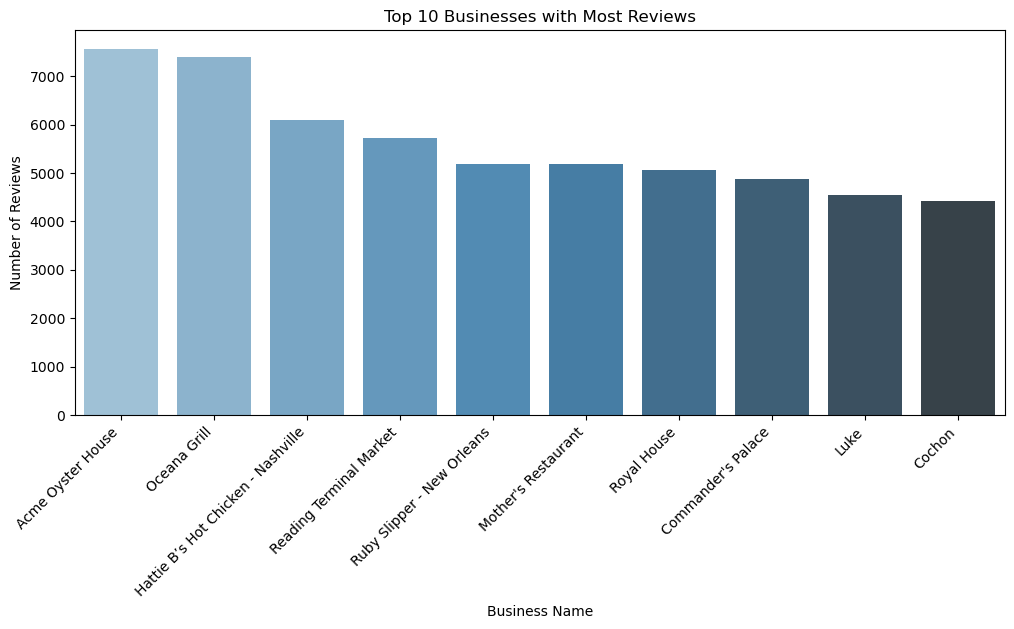

In [26]:
top_business = df_business.nlargest(10, 'review_count')

plt.figure(figsize=(12, 5))
sns.barplot(data=top_business, x="name", y="review_count", palette="Blues_d")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Businesses with Most Reviews")
plt.xlabel("Business Name")
plt.ylabel("Number of Reviews")
plt.show()


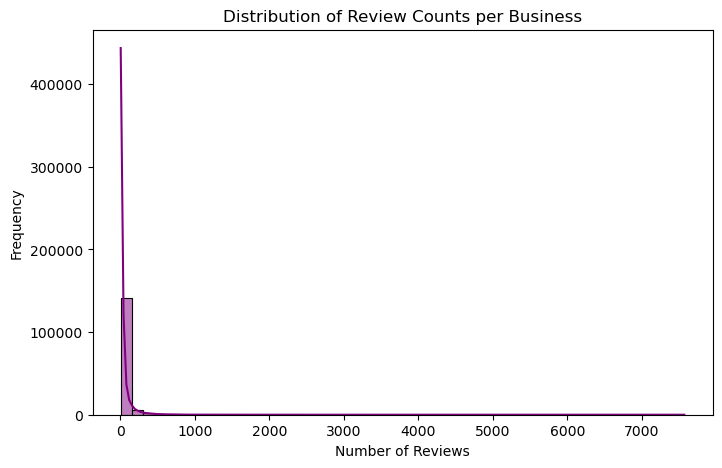

In [28]:
plt.figure(figsize=(8, 5))
sns.histplot(df_business['review_count'], bins=50, kde=True, color="purple")
plt.title("Distribution of Review Counts per Business")
plt.xlabel("Number of Reviews")
plt.ylabel("Frequency")
#plt.xscale("log") 
plt.show()


/tmp/ipykernel_3895/1697198628.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories, x="Category", y="Count", palette="coolwarm")


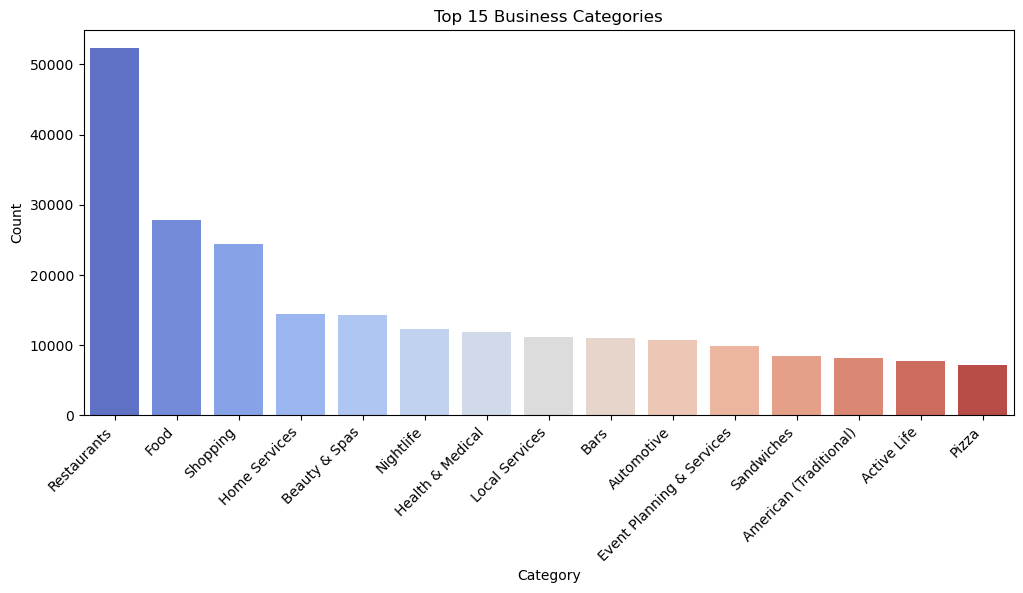

In [ ]:

categories = df_business['categories'].dropna().str.split(', ').explode()
top_categories = pd.DataFrame(Counter(categories).most_common(15), columns=['Category', 'Count'])

plt.figure(figsize=(12, 5))
sns.barplot(data=top_categories, x="Category", y="Count", palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.title("Top 15 Business Categories")
plt.show()


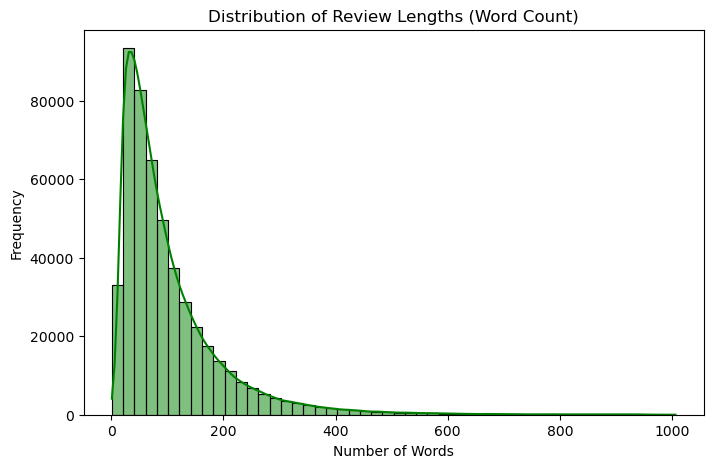

In [30]:
df_review["review_length"] = df_review["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df_review["review_length"], bins=50, kde=True, color="green")
plt.title("Distribution of Review Lengths (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


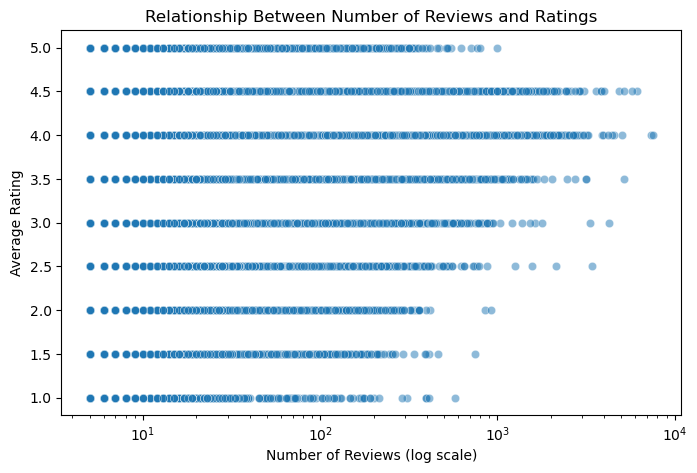

In [31]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_business, x="review_count", y="stars", alpha=0.5)
plt.xscale("log")  # Log scale for better visualization
plt.title("Relationship Between Number of Reviews and Ratings")
plt.xlabel("Number of Reviews (log scale)")
plt.ylabel("Average Rating")
plt.show()


/tmp/ipykernel_3895/2890383428.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users, x="user_id", y="review_count", palette="Reds_d")


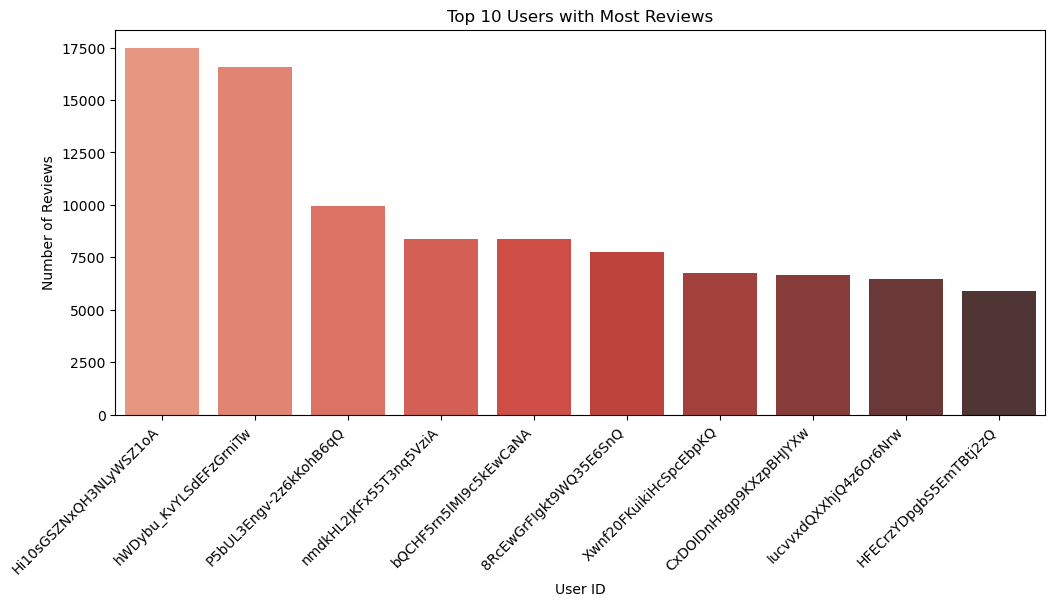

In [32]:
top_users = df_user.nlargest(10, "review_count")

plt.figure(figsize=(12, 5))
sns.barplot(data=top_users, x="user_id", y="review_count", palette="Reds_d")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Users with Most Reviews")
plt.xlabel("User ID")
plt.ylabel("Number of Reviews")
plt.show()


/tmp/ipykernel_4466/375514905.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_review, x="sentiment", palette="Set1")


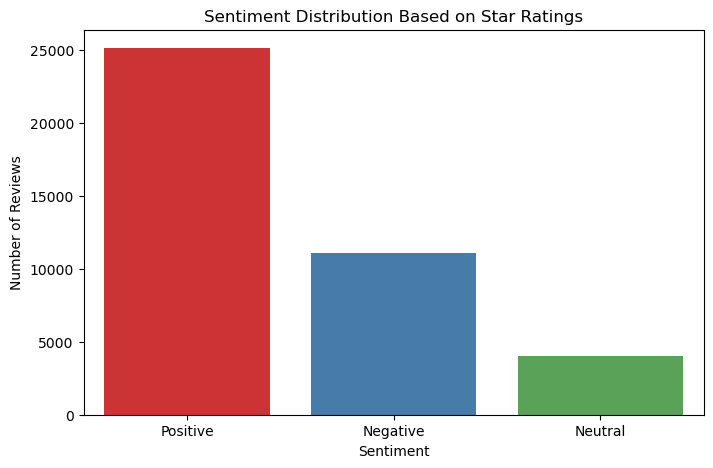

In [9]:
df_review["sentiment"] = df_review["stars"].apply(lambda x: "Positive" if x >= 4 else "Negative" if x <= 2 else "Neutral")

plt.figure(figsize=(8, 5))
sns.countplot(data=df_review, x="sentiment", palette="Set1")
plt.title("Sentiment Distribution Based on Star Ratings")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()


/tmp/ipykernel_3895/4100359952.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_categories, x="stars", y="categories", palette="viridis")


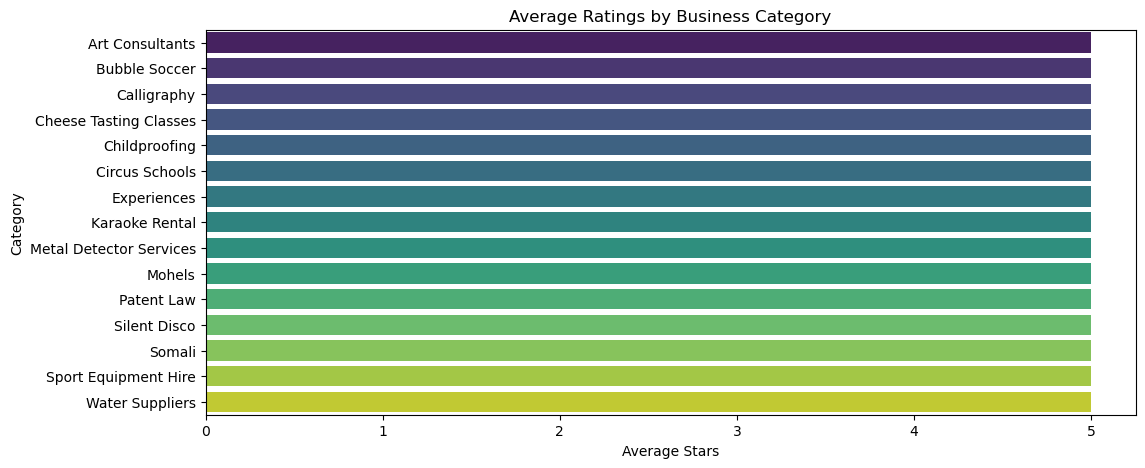

In [34]:
df_categories = df_business[['categories', 'stars']].dropna()
df_categories = df_categories.assign(categories=df_categories['categories'].str.split(', ')).explode('categories')
df_categories = df_categories.groupby('categories')['stars'].mean().reset_index()
df_categories = df_categories.nlargest(15, 'stars')

plt.figure(figsize=(12, 5))
sns.barplot(data=df_categories, x="stars", y="categories", palette="viridis")
plt.title("Average Ratings by Business Category")
plt.xlabel("Average Stars")
plt.ylabel("Category")
plt.show()


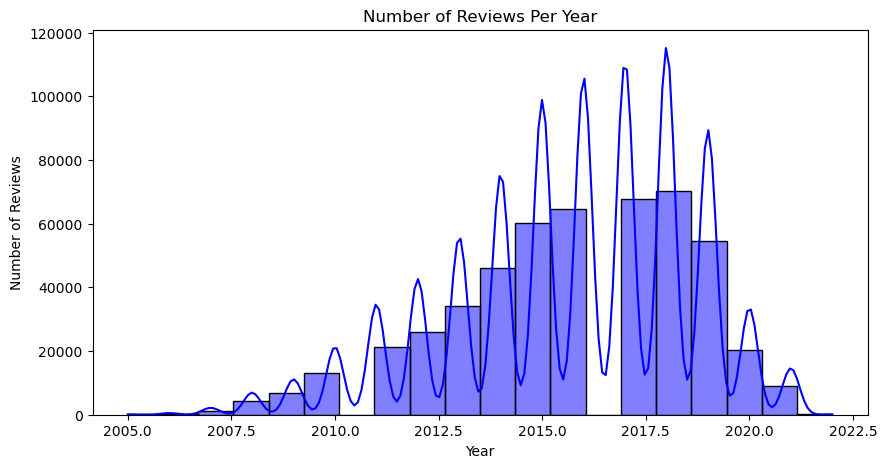

In [35]:
df_review["year"] = pd.to_datetime(df_review["date"]).dt.year

plt.figure(figsize=(10, 5))
sns.histplot(df_review["year"], bins=20, kde=True, color="blue")
plt.title("Number of Reviews Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.show()


## pre-processing

In [12]:

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


def preprocess_texts(texts):
    processed_texts = []
    
    for text in tqdm(texts, desc="Processing texts"):
        text = text.lower().strip()  # Lowercase and remove extra spaces

        # Remove special characters but keep numbers
        text = re.sub(r'[^a-zA-Z0-9 ]', '', text)

        # Tokenization, stopword removal, and lemmatization
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc if not token.is_stop]

        processed_texts.append(" ".join(tokens))
    
    return processed_texts



In [13]:
df_review["clean_text"] = df_review["text"].apply(preprocess_text)
print(" pre-processin finished!")


 pre-processin finished!


### Deep sentiment analysis using Hybrid Aprroach *(Sentiment CLassification(positive, neural, negativa))* and *(Emotion Detection (joy, sadness, anger, etc))*

In [14]:

# Sentiment model (positive/neutral/negative)
sentiment_classifier = pipeline("sentiment-analysis", model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

# Emotion model (joy, sadness, anger, etc.)
emotion_classifier = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion")

# Function for sentiment classification
def classify_sentiment(text):
    result = sentiment_classifier(text)
    return result[0]['label']

# Function for emotion classification
def classify_emotion(text):
    result = emotion_classifier(text)
    return result[0]['label']




Device set to use cuda:0
Device set to use cuda:0


In [15]:
from tqdm import tqdm
import time

# Start tracking time
start_time = time.time()

# Ensure the text is truncated to the first 512 characters
df_review["short_text"] = df_review["clean_text"].apply(lambda x: x[:512] if isinstance(x, str) else "")

# Apply sentiment analysis 
print("Applying sentiment analysis...")
df_review["sentiment"] = [classify_sentiment(text) for text in tqdm(df_review["short_text"], desc="Sentiment Analysis", total=len(df_review))]

# Apply emotion analysis 
print("Applying emotion analysis...")
df_review["emotion"] = [classify_emotion(text) for text in tqdm(df_review["short_text"], desc="Emotion Analysis", total=len(df_review))]

# Calculate elapsed time
elapsed_time = time.time() - start_time
print(f"Total time taken: {elapsed_time:.2f} seconds")

print("Sentiment and Emotion classification completed!")


Applying sentiment analysis...


Sentiment Analysis:   0%|          | 0/40186 [00:00<?, ?it/s]

Sentiment Analysis: 100%|██████████| 40186/40186 [04:15<00:00, 157.20it/s]


Applying emotion analysis...


Emotion Analysis: 100%|██████████| 40186/40186 [06:55<00:00, 96.77it/s] 

Total time taken: 670.91 seconds
Sentiment and Emotion classification completed!


In [18]:
print(df_review[["text", "sentiment", "emotion"]].head())

                                                text sentiment emotion
0  Best pizza ever... hands down.\n\nLove the pee...  positive     joy
1  I didn't really like my sandwich I got here. I...  negative     joy
2  This is a must get when you come to Reno is Ye...  positive     joy
3  Yummy food,  they will veganize things for you...  positive     joy
4  The new Bacon-Bleu cheeseburger is excellent! ...  positive     joy


/tmp/ipykernel_3895/1457956623.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_review, x="sentiment", palette="coolwarm", order=df_review["sentiment"].value_counts().index)


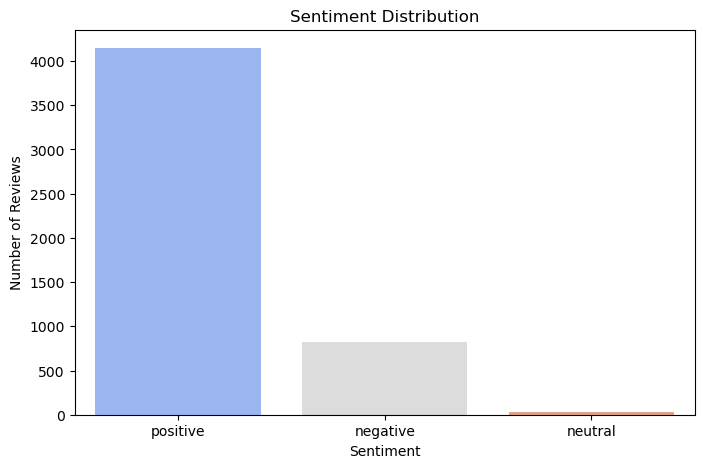

/tmp/ipykernel_3895/1457956623.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_review, x="emotion", palette="coolwarm", order=df_review["emotion"].value_counts().index)


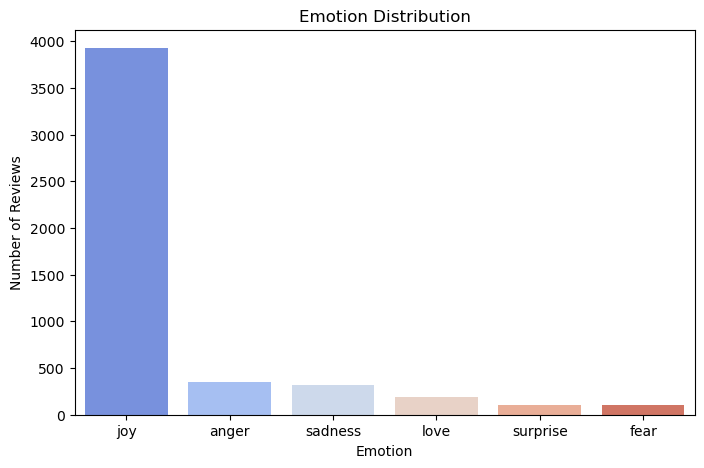

In [111]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_review, x="sentiment", palette="coolwarm", order=df_review["sentiment"].value_counts().index)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

# Plot Emotion Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df_review, x="emotion", palette="coolwarm", order=df_review["emotion"].value_counts().index)
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Number of Reviews")
plt.show()

In [94]:
# TUDO ABAIXO É TESTES

## TUDO we can train the model (see later)

### Hybrid aproach *(Content-Based Filtering and Collaborative Filtering)* with emotion and sentiment analysy, get best restaurants (alterei ja n sei se corresponde)

In [ ]:
# usar vectores semanticos para encontrar similaridade entre reviews

#exemplo abaixo só para testar

In [19]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from geopy.distance import geodesic
from transformers import BertTokenizer, BertModel
import torch

In [20]:

# Função para calcular a distância entre duas coordenadas
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km


In [21]:
from tqdm import tqdm

def best_restaurants_bert(user_id=None, lat=None, lon=None, max_distance=5, top_n=10, min_rating=3.5):
    if not user_id:
        return None  
    
    filtered_business = df_restaurants.copy()  

    user_reviews = df_review[df_review["user_id"] == user_id]
    
    if user_reviews.empty:
        return None  
    
    positive_reviews = user_reviews[user_reviews["stars"] >= min_rating]
    reviewed_businesses = positive_reviews["business_id"].unique()

    # 3. Obter índices dos restaurantes que o usuário avaliou
    idx_list = df_restaurants[df_business["business_id"].isin(reviewed_businesses)].index.tolist()

    similar_businesses = set()
    
    # 4. Encontrar restaurantes similares
    for idx in tqdm(idx_list, desc="Buscando restaurantes similares"):
        sim_scores = list(enumerate(cosine_similarity[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = [df_restaurants.iloc[i[0]]["business_id"] for i in sim_scores[1:top_n + 1]]
        similar_businesses.update(sim_scores)

    # 5. Filtrar restaurantes similares que foram avaliados pelo usuário e outros usuários
    filtered_business = df_business[df_business["business_id"].isin(similar_businesses)]
    
    # 6. Incluir as avaliações do próprio usuário na média de notas
    business_ratings = df_review[df_review["business_id"].isin(filtered_business["business_id"])]
    avg_ratings = business_ratings.groupby("business_id")["stars"].mean().reset_index()
    
    # 7. Mesclar a média das avaliações com o DataFrame de restaurantes
    filtered_business = filtered_business.merge(avg_ratings, on="business_id", how="left")

    # 8. Filtrar por distância, se necessário
    if lat and lon:
        filtered_business["distance"] = filtered_business.apply(
            lambda row: calculate_distance(lat, lon, row["latitude"], row["longitude"]), axis=1
        )
        filtered_business = filtered_business[filtered_business["distance"] <= max_distance]

    # 9. Ordenar pelos melhores restaurantes (rating médio)
    return filtered_business.sort_values(by="stars", ascending=False).head(top_n)


In [29]:
df_user.head()


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987892,fB3jbHi3m0L2KgGOxBv6uw,Jerrold,23,2015-01-06 00:31:31,7,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
1987893,68czcr4BxJyMQ9cJBm6C7Q,Jane,1,2016-06-14 07:20:52,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
1987894,1x3KMskYxOuJCjRz70xOqQ,Shomari,4,2017-02-04 15:31:58,1,1,0,,None,0,...,0,0,0,0,0,0,0,0,0,0
1987895,ulfGl4tdbrH05xKzh5lnog,Susanne,2,2011-01-14 00:29:08,0,0,0,,None,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
print(best_restaurants_bert(user_id="j14WgRoU_-2ZE1aw1dXrJg", top_n=10))


None


In [34]:
def best_restaurants(user_id=None, lat=None, lon=None, category=None, emotion=None, min_sentiment=0, max_distance=5, top_n=10,
                     weight_stars=0.4, weight_reviews=0.3, weight_sentiment=0.2, weight_distance=0.1):
    """
    Determina os melhores restaurantes usando uma pontuação híbrida considerando:
    - User ID (opcional) → Preferências baseadas no histórico do usuário
    - Localização (opcional) → Restaurantes próximos
    - Tipo de comida/categoria (opcional) → Filtrar por tipo de restaurante
    - Emoção (opcional) → Filtrar por emoções específicas (ex: alegria)
    - Sentimento (opcional) → Considerar apenas avaliações com sentimento acima de min_sentiment
    - Peso ajustável para estrelas, número de reviews, sentimento e distância
    """

    # 1️⃣ **Filtrar por categoria, se especificada**
    if category:
        filtered_business = df_business[df_business["categories"].str.contains(category, case=False, na=False)]
    else:
        filtered_business = df_business.copy()

    # 2️⃣ **Filtrar por localização, se informado**
    if lat and lon:
        filtered_business["distance"] = filtered_business.apply(
            lambda row: geodesic((lat, lon), (row["latitude"], row["longitude"])).km, axis=1
        )
        filtered_business = filtered_business[filtered_business["distance"] <= max_distance]

    # 3️⃣ **Se houver User ID, pegar suas avaliações e encontrar negócios similares**
    if user_id:
        user_reviews = df_review[df_review["user_id"] == user_id]
        if not user_reviews.empty:
            reviewed_businesses = user_reviews["business_id"].unique()
            idx_list = df_business[df_business["business_id"].isin(reviewed_businesses)].index.tolist()
            
            similar_businesses = set()
            for idx in idx_list:
                sim_scores = list(enumerate(cosine_similarity[idx]))
                sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
                sim_scores = [df_business.iloc[i[0]]["business_id"] for i in sim_scores[1:top_n+1]]
                similar_businesses.update(sim_scores)
            
            # Filtrar os restaurantes que são similares aos que o usuário já avaliou
            filtered_business = filtered_business[filtered_business["business_id"].isin(similar_businesses)]

    # 4️⃣ **Juntar avaliações e aplicar filtro de sentimento e emoção**
    merged = filtered_business.merge(df_review, on="business_id")
    # Filtrar por sentimento (se especificado)
    if min_sentiment is not None:
        merged = merged[merged["sentiment"] == "positive"]
    
    # Filtrar por emoção específica (se especificado)
    if emotion:
        merged = merged[merged["emotion"] == emotion]

    # 5️⃣ **Criar a pontuação híbrida**
    merged["sentiment_score"] = merged["sentiment"].apply(lambda x: 1 if x == "positive" else (0 if x == "neutral" else -1))
    merged["distance_score"] = 1 / (1 + merged["distance"]) if "distance" in merged else 1  # Inverter para dar mais peso aos próximos

    # Usando o nome correto da coluna "stars" se estiver renomeado após o merge
    merged["hybrid_score"] = (
        weight_stars * merged.get("stars", 0) +  # Use get para evitar KeyError
        weight_reviews * np.log1p(merged["review_count"]) +  # Log para balancear grande quantidade de reviews
        weight_sentiment * merged["sentiment_score"] +
        weight_distance * merged["distance_score"]
    )

    # Ordenar pelos melhores restaurantes segundo a pontuação híbrida
    top_restaurants = (
        merged.groupby(["business_id", "name"])
        .agg({"hybrid_score": "mean"})
        .sort_values("hybrid_score", ascending=False)
        .head(top_n)
    )
    
    return top_restaurants.reset_index()


In [35]:
print(best_restaurants(user_id="j14WgRoU_-2ZE1aw1dXrJg",top_n=5))


              business_id                  name  hybrid_score
0  ve_-rPlEGPClytyJtY55Vw  Nugget Casino Resort      2.508984
1  hjRxa6xpKOwnbUgGvVCE5Q    Sparks Coffee Shop      2.308369
2  8QqnRpM-QxGsjDNuu0E57A      Carlillos Cocina      2.305384
3  TF3qNGUBUgIYp6u0j79JHQ  BJ's Nevada Barbecue      2.266607
4  W72rYffSVg0pIaOpRgNniw   Grimaldi's Pizzeria      2.261007


In [93]:
print(best_restaurants(category="Chinese", top_n=5))


              business_id                   name  hybrid_score
0  mcr1lAEdvGLMJhuPwI3I2A  101 Taiwanese Cuisine      2.413210
1  eaDZlSuVS0EY67Ke6pRP6Q                 Penang      2.404444
2  MMRRS6YhVRx_iN5-JhMRYg            Han Dynasty      2.299323
3  w520vYWEpEYBf90rSr9NVA   The Smiling Elephant      2.221569
4  dpwkz52tHB2MCPv53I2aRA                Jazmine      2.136748


In [71]:
print(best_restaurants(lat=40.7128, lon=-74.0060, emotion="joy", top_n=5))


Empty DataFrame
Columns: [business_id, name, hybrid_score]
Index: []


In [92]:
print(best_restaurants(min_sentiment="negative", top_n=5))


              business_id                             name  hybrid_score
0  GBTPC53ZrG1ZBY3DT8Mbcw                             Luke      2.827194
1  PY9GRfzr4nTZeINf346QOw                  Peppermill Reno      2.645650
2  SZU9c8V2GuREDN5KgyHFJw  Santa Barbara Shellfish Company      2.635592
3  UCMSWPqzXjd7QHq7v8PJjQ                    Prep & Pastry      2.598740
4  vN6v8m4DO45Z4pp8yxxF_w        Surrey's Café & Juice Bar      2.592757


In [95]:
from transformers import BertTokenizer, BertModel


In [112]:

# Carregar o modelo BERT e tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [114]:
# Função para obter o embedding de uma avaliação com BERT
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Média dos embeddings de todas as palavras
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [115]:
# Aplicar o BERT em todas as avaliações
def apply_bert_to_reviews(df_review):
    df_review['embedding'] = df_review['clean_text'].apply(lambda x: get_bert_embedding(x) if isinstance(x, str) else np.zeros(768))
    return df_review

In [121]:
df_review = apply_bert_to_reviews(df_review)

In [ ]:
def best_restaurants_bert(user_id = None, lat = None, lon = None, max_distance=5, top_n = 10):
    
    if user_id:
        user_reviews = df_review[df_review["user_id"] == user_id]
        if not user_reviews.empty:
            reviewed_businesses = user_reviews["business_id"].unique()
            idx_list = df_business[df_business["business_id"].isin(reviewed_businesses)].index.tolist()
            
            similar_businesses = set()
            for idx in idx_list:
                sim_scores = list(enumerate(cosine_sim[idx]))
                sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
                sim_scores = [df_business.iloc[i[0]]["business_id"] for i in sim_scores[1:top_n+1]]
                similar_businesses.update(sim_scores)
            
            # Filtrar os restaurantes que são similares aos que o usuário já avaliou
            filtered_business = filtered_business[filtered_business["business_id"].isin(similar_businesses)]
    if lat and lon:
        filtered_business["distance"] = filtered_business.apply(
            lambda row: calculate_distance(lat, lon, row["latitude"], row["longitude"]), axis=1
        )
        filtered_business = filtered_business[filtered_business["distance"] <= max_distance]
    


    

In [ ]:


def best_restaurants_bert(user_id=None, lat=None, lon=None, category=None, emotion=None, min_sentiment=0, max_distance=5, top_n=10,
                          weight_reviews=0.3, weight_sentiment=0.3, weight_distance=0.2, weight_similarity=0.2):
    """
    Recomendação de restaurantes usando BERT para embeddings, localizações, sentimentos, e emoções.
    """


    # 1️⃣ **Filtrar por categoria, se especificada**
    if category:
        filtered_business = df_business[df_business["categories"].str.contains(category, case=False, na=False)]
    else:
        filtered_business = df_business.copy()

    # 2️⃣ **Filtrar por localização, se informado**
    if lat and lon:
        filtered_business["distance"] = filtered_business.apply(
            lambda row: calculate_distance(lat, lon, row["latitude"], row["longitude"]), axis=1
        )
        filtered_business = filtered_business[filtered_business["distance"] <= max_distance]

    # 3️⃣ **Se houver User ID, pegar suas avaliações e encontrar negócios similares**
    if user_id:
        user_reviews = df_review[df_review["user_id"] == user_id]
        if not user_reviews.empty:
            reviewed_businesses = user_reviews["business_id"].unique()
            idx_list = df_business[df_business["business_id"].isin(reviewed_businesses)].index.tolist()
            
            similar_businesses = set()
            for idx in idx_list:
                # Calcular a similaridade entre o embedding da avaliação do restaurante e todos os embeddings
                sim_scores = cosine_similarity([df_review.iloc[idx]['embedding']], df_review['embedding'])
                sim_scores = sim_scores.flatten()  # Transformar a matriz 2D em um vetor 1D
                top_similar = np.argsort(sim_scores)[1:top_n+1]  # Pegue os top_n mais similares
                similar_businesses.update(df_review.iloc[top_similar]["business_id"].values)
            
            # Filtrar os restaurantes que são similares aos que o usuário já avaliou
            filtered_business = filtered_business[filtered_business["business_id"].isin(similar_businesses)]

    # 4️⃣ **Juntar avaliações e aplicar filtro de sentimento e emoção**
    merged = filtered_business.merge(df_review, on="business_id")

    # Filtrar por sentimento (se especificado)
    if min_sentiment is not None:
        merged = merged[merged["sentiment"] == "positive"]
    
    # Filtrar por emoção específica (se especificado)
    if emotion:
        merged = merged[merged["emotion"] == emotion]

    # 5️⃣ **Calcular a pontuação híbrida**

    # Normalizar a pontuação de sentimento (Positivo=1, Negativo=-1, Neutro=0)
    merged["sentiment_score"] = merged["sentiment"].apply(lambda x: 1 if x == "positive" else (-1 if x == "negative" else 0))
    
    # Calcular a pontuação de similaridade
    merged["similarity_score"] = merged.apply(
        lambda row: cosine_similarity([row['embedding']], df_review['embedding']).mean(), axis=1
    )

    # Calcular a distância
    merged["distance_score"] = 1 / (1 + merged["distance"]) if "distance" in merged else 1  # Inverter para dar mais peso aos próximos

    # Combinar os fatores com pesos ajustáveis
    merged["hybrid_score"] = (
        weight_reviews * np.log1p(merged["review_count"]) +  # Log para balancear grande quantidade de reviews
        weight_sentiment * merged["sentiment_score"] +
        weight_distance * merged["distance_score"] +
        weight_similarity * merged["similarity_score"]
    )

    # 6️⃣ **Ordenar pelos melhores restaurantes segundo a pontuação híbrida**
    top_restaurants = (
        merged.groupby(["business_id", "name"])
        .agg({"hybrid_score": "mean"})
        .sort_values("hybrid_score", ascending=False)
        .head(top_n)
    )
    
    return top_restaurants.reset_index()



In [125]:
best_restaurants_bert(category='Italian', top_n=5)


ValueError: setting an array element with a sequence.